In [1]:

import os


os.chdir('/Users/alex/ZSCIR/')

print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/alex/ZSCIR


In [2]:
import json
from typing import List

import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from clip import tokenize
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection, CLIPImageProcessor
from PIL import Image

from src.fashioniq_experiment.utils import element_wise_sum_original, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original, get_combing_function_with_rq
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search_clip, \
    compute_results_fiq_val_clip
from src.utils import device

from model.rqkmeans import RQKmeans
from src.fashioniq_experiment.tokenize.run_rqkmeans import ModelCfg, Cfg

In [3]:
cache = {}
CLIP_NAME = 'laion/CLIP-ViT-B-32-laion2B-s34B-b79K'
clip_text_encoder = CLIPTextModelWithProjection.from_pretrained(CLIP_NAME, torch_dtype=torch.float32, projection_dim=512)
clip_text_encoder = clip_text_encoder.float().to(device)

print("clip text encoder loaded.")
clip_text_encoder.eval()
clip_tokenizer = tokenize

clip text encoder loaded.

In [4]:
print('CLIP preprocess pipeline is used')
preprocess = CLIPImageProcessor(
    crop_size={'height': 224, 'width': 224},
    do_center_crop=True,
    do_convert_rgb=True,
    do_normalize=True,
    do_rescale=True,
    do_resize=True,
    image_mean=[0.48145466, 0.4578275, 0.40821073],
    image_std=[0.26862954, 0.26130258, 0.27577711],
    resample=3,
    size={'shortest_edge': 224},
)
clip_img_encoder = CLIPVisionModelWithProjection.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K")

CLIP preprocess pipeline is used

In [5]:
with open('./fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 15412

In [6]:
model_cfg = ModelCfg(
    num_book=10,
    num_cluster=[256, 256, 256, 256, 256, 256, 256, 256, 256, 256],
    dim=512,
)
cfg = Cfg(model=model_cfg, seed=42, device="cpu")
rq_tokenize = RQKmeans(cfg=cfg)
rq_tokenize.load_state_dict(torch.load('./model/checkpoints/tokenize/rqkmeans.pth'))
rq_tokenize.eval()

RQKmeans()

In [20]:
image_1_path = 'fashionIQ_dataset/images/B005X4PL1G.jpg'
image_2_path = 'fashionIQ_dataset/images/B00AKLK08G.jpg'
image_1_emb = clip_image_encoder(torch.tensor(preprocess(Image.open(image_1_path))['pixel_values'][0]).unsqueeze(0)).image_embeds
image_2_emb = clip_image_encoder(torch.tensor(preprocess(Image.open(image_2_path))['pixel_values'][0]).unsqueeze(0)).image_embeds
sid1, res1 = rq_tokenize(image_1_emb)
sid2, res2 = rq_tokenize(image_2_emb)
print("Image 1 RQKmeans codes:", sid1)
print("Image 2 RQKmeans codes:", sid2)



NameError: name 'clip_image_encoder' is not defined

In [8]:
from torch.nn import functional as F

cosine_list = []
# Iterate over the number of codebooks
for i in range(rq_tokenize.num_book):
    current_codebook = getattr(rq_tokenize, f'codebook_{i}')
    
    vec1 = current_codebook[int(sid1[0][i])]
    vec2 = current_codebook[int(sid2[0][i])]
    
    cosine_sim = F.cosine_similarity(vec1, vec2, dim=0)
    cosine_list.append(cosine_sim.item())

print(cosine_list)

[
    0.7556193470954895,
    -0.3565499484539032,
    0.0624077282845974,
    0.212980717420578,
    -0.09541627764701843,
    -0.060923583805561066,
    -0.10402385890483856,
    0.03438896685838699,
    -0.023306557908654213,
    0.04429163783788681
]

In [9]:
F.cosine_similarity(image_1_emb, image_2_emb, dim=1)

tensor([0.5535], grad_fn=<SumBackward1>)

In [10]:
caption = "is grey with black design. is a light printed short dress"
text_emb = clip_text_encoder(clip_tokenizer(caption)).text_embeds
sidt, rest = rq_tokenize(text_emb)
F.cosine_similarity(text_emb, image_2_emb, dim=1)

tensor([0.3156], grad_fn=<SumBackward1>)

In [11]:
cosine_i2t_list = []
# Iterate over the number of codebooks
for i in range(rq_tokenize.num_book):
    current_codebook = getattr(rq_tokenize, f'codebook_{i}')
    
    vec1 = current_codebook[int(sid1[0][i])]
    vec2 = current_codebook[int(sidt[0][i])]
    
    cosine_sim = F.cosine_similarity(vec1, vec2, dim=0)
    cosine_i2t_list.append(cosine_sim.item())

print(cosine_i2t_list)

[
    0.7636755108833313,
    -0.08335895836353302,
    0.01014978252351284,
    0.0874435156583786,
    0.014826285652816296,
    -0.007738926913589239,
    0.10203336179256439,
    -0.052395518869161606,
    0.0008900049142539501,
    -0.05506715551018715
]

In [12]:
image_1_emb_decode = rq_tokenize.decode(sid1)
image_2_emb_decode = rq_tokenize.decode(sid2)
sid_sim = F.cosine_similarity(image_1_emb_decode, image_2_emb_decode, dim=-1) 
sid_sim

tensor([[ 0.7556, -0.3565,  0.0624,  0.2130, -0.0954, -0.0609, -0.1040,  0.0344,
         -0.0233,  0.0443]])

In [13]:
text_emb_decode = rq_tokenize.decode(sidt)

In [14]:
alpha = 0.5
idx_1 = [0, 2, 3, 4, 6, 8, 9]
idx_2 = [1, 5, 7]
image_1_emb_fusion = (1 - alpha) * image_1_emb_decode[0][idx_1].sum(dim=0)+ alpha * text_emb_decode[0][idx_1].sum(dim=0)
image_1_emb_weion = (1 - alpha) * image_1_emb + alpha * text_emb
fusion_sim = F.cosine_similarity(image_1_emb_fusion, image_2_emb, dim=-1) 
fusion_sim_weion = F.cosine_similarity(image_1_emb_weion, image_2_emb, dim=-1)
print(fusion_sim)
print(fusion_sim_weion)

tensor([0.7150], grad_fn=<SumBackward1>)

tensor([0.5836], grad_fn=<SumBackward1>)

In [7]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'dress',
        get_combing_function_with_rq(alpha, rq_tokenize),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

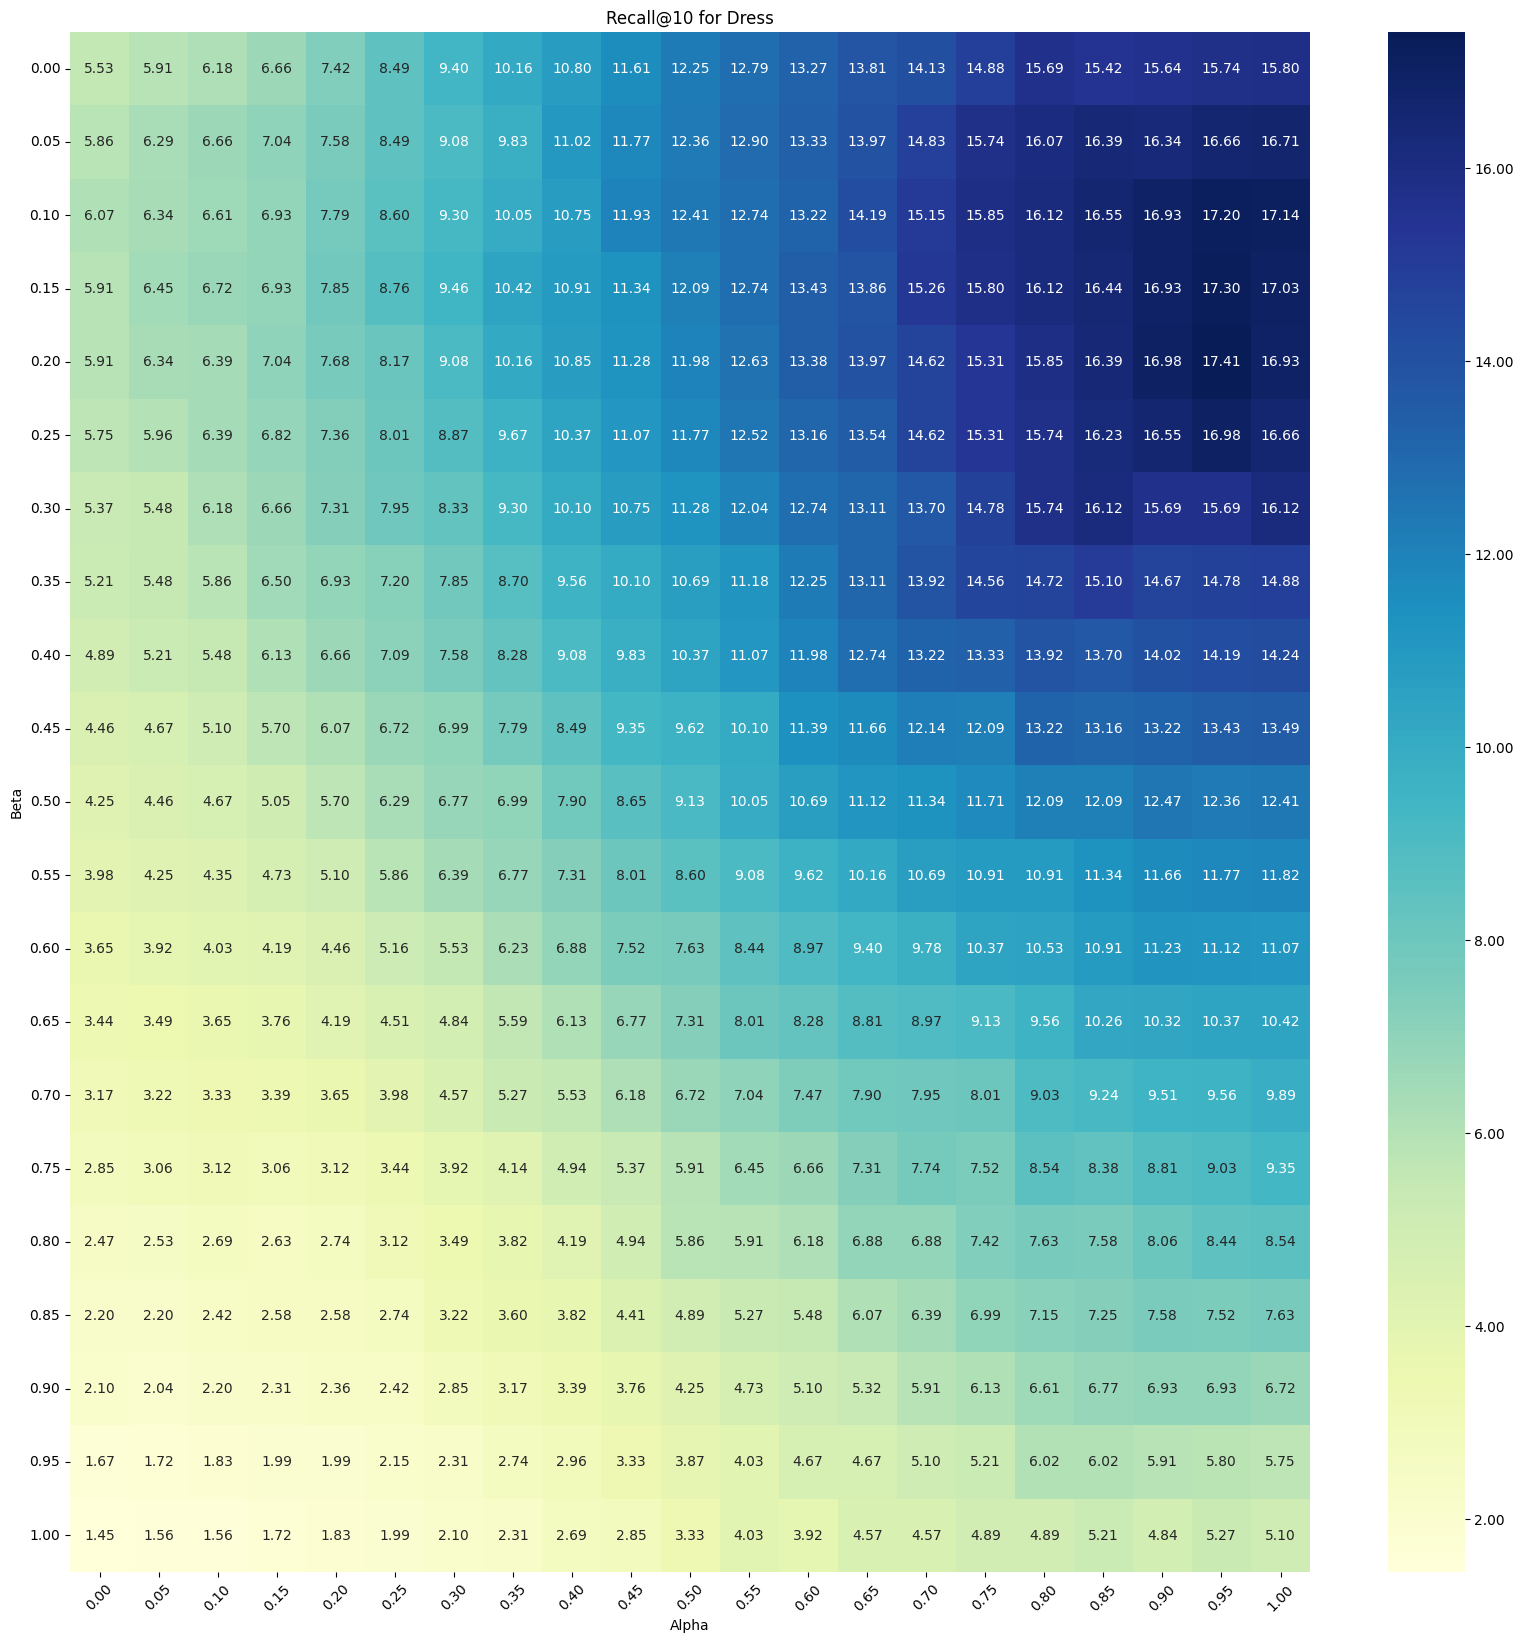

In [8]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")
